# Multi Axion System

In [11]:
%run observables.py
%run multi_axion.py

In [25]:
Q = np.array([[1,1], [1, 0]])
Q_inv = np.linalg.inv(Q)
eps = 1e-3
Lambda = 1e7**2 * np.array([1, 1 + eps]) # [GeV]
thetas0 = [1, -1]
H_inf = Gamma_inf = 1e8
tmax_axion_time = 10.0

energy_scale, conv_factor, rho_R_init, rho_inf_init, scale, tmax_inf_time, red_chem_pots_init = \
    init_system(H_inf, Gamma_inf, (Q, Lambda), multi_axion_field, tmax_axion_time)

sol, T_and_H_fn, _ = decay_process.solve(tmax_inf, rho_R_init, rho_inf_init, scale, Gamma_inf)

axsol = multi_axion_field.solve(np.hstack([thetas0, np.zeros(len(Lambda))]), (Q, Lambda), tmax_axion, T_and_H_fn, Gamma_inf)

In [21]:
ts = np.linspace(0, tmax_axion, 500)
y = axsol.sol(ts) 

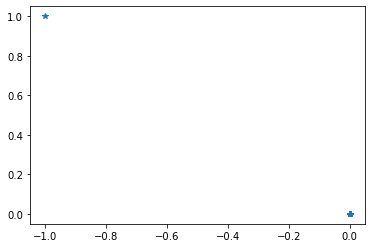

In [24]:
plt.plot(y[1,:], y[0,:],"*")